In [1]:
import torch
import torch
from torch.autograd import Variable as V
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
import numpy as np
import argparse
import time
torch.__version__
# WOOO!
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [8]:
LATENT_DIM = 2
BATCH_SIZE = 100

In [9]:
train_dataset = datasets.MNIST(root='./data/',
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = datasets.MNIST(root='./data/',
                           train=False, 
                           transform=transforms.ToTensor())

print(len(train_dataset))
print(len(test_dataset))
# train_dataset[0][0]

torch.manual_seed(3435)
train_img = torch.stack([torch.bernoulli(d[0]) for d in train_dataset])
train_label = torch.LongTensor([d[1] for d in train_dataset])
test_img = torch.stack([torch.bernoulli(d[0]) for d in test_dataset])
test_label = torch.LongTensor([d[1] for d in test_dataset])
# print(train_img[0])
print(train_img.size(), train_label.size(), test_img.size(), test_label.size())

# MNIST does not have an official train dataset. So we will use the last 10000 training points as your validation set.
val_img = train_img[-10000:].clone()
val_label = train_label[-10000:].clone()
train_img = train_img[:-10000] # TODO: this should be -10000 right?
train_label = train_label[:-10000]

train = torch.utils.data.TensorDataset(train_img, train_label)
val = torch.utils.data.TensorDataset(val_img, val_label)
test = torch.utils.data.TensorDataset(test_img, test_label)
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

img, label = next(iter(train_loader))
print(img.size(),label.size())

60000
10000
torch.Size([60000, 1, 28, 28]) torch.Size([60000]) torch.Size([10000, 1, 28, 28]) torch.Size([10000])
torch.Size([100, 1, 28, 28]) torch.Size([100])


In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 200)
        self.linear2 = nn.Linear(200, LATENT_DIM)
        self.linear3 = nn.Linear(200, LATENT_DIM)
    def forward(self, x):
        x = x.view(-1,784)
        h = F.relu(self.linear1(x))
        return self.linear2(h), self.linear3(h)

# generate 784-dim x given latent-dim z
# Implement the generative model p(x | z)
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(LATENT_DIM, 200)
        self.linear2 = nn.Linear(200, 784)
    def forward(self, z):
        out = self.linear2(F.relu(self.linear1(z)))
        return out.view(-1,28,28)

# VAE using reparameterization "rsample"
class NormalVAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(NormalVAE, self).__init__()
        # Parameters phi and computes variational parameters lambda
        self.encoder = encoder
        # Parameters theta, p(x | z)
        self.decoder = decoder
    def forward(self, x_src):
        # Example variational parameters lambda
        mu, logvar = self.encoder(x_src)
        q_normal = Normal(loc=mu, scale=logvar.mul(0.5).exp()) # TODO: shouldn't it be .exp().mul(0.5)?
        # Reparameterized sample.
        z_sample = q_normal.rsample()
        # z_sample = mu (no sampling)
        return self.decoder(z_sample), q_normal

In [ ]:
# Problem setup.
encoder = Encoder()
decoder = Decoder()
vae = NormalVAE(encoder, decoder)
vae.load_state_dict(torch.load('../HW4/stupidvae.pkl'))

In [4]:
# viz 1: generate a digit
seed_distribution = Normal(V(torch.zeros(1,LATENT_DIM)).cuda(), 
                        V(torch.ones(1,LATENT_DIM)).cuda())
def graph_vae():
    seed = seed_distribution.sample()
    x = decoder(seed) # 1,28,28
    plt.imshow(x[0].data.numpy())
    
graph_vae()

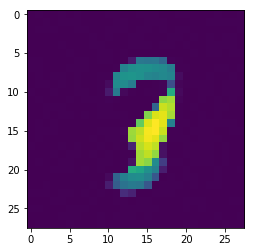

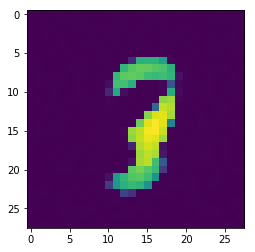

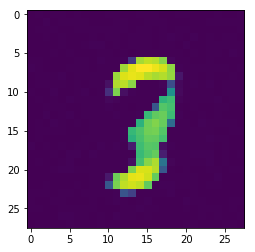

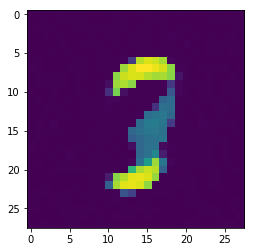

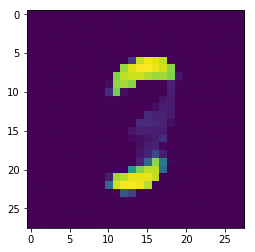

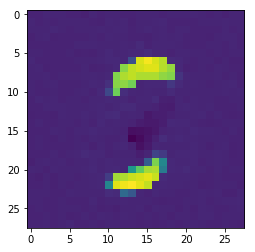

In [6]:
z1 = seed_distribution.sample()
z2 = seed_distribution.sample()
all = []
for k in np.arange(0,1.1,0.2):
    z = k * z1 + (1 - k) * z2
    x = decoder(z)
    all.append(x[0].data.numpy()) # TODO: might not work
    plt.imshow(x[0].data.numpy())
    plt.show()

In [10]:
# viz 3: scatter plot of variational means
mus = []
cols = []
for img, label in test_loader:
    img = img.squeeze(1)
    img = V(img).cuda()
    mu, logvar = encoder(img) # bs,2
    mus.append(mu.cpu().data.numpy())
    cols.append(label.cpu().data.numpy())

mus = np.vstack(mus)
cols = np.concatenate(cols)
wheel = cm.rainbow(np.linspace(0,1,10))
for i in range(10):
    mu_i = mus[cols==i]
    plt.scatter(mu_i[:,0],mu_i[:,1],c=wheel[i])

plt.legend([str(i) for i in range(10)])
plt.show()

RuntimeError: Expected object of type torch.FloatTensor but found type torch.cuda.FloatTensor for argument #4 'mat1'

In [ ]:
# viz 4
# for each point in the grid, generate x and show digit in 2d plot
# taken from altosaar demo on github
nx = ny = 20
x_values = np.linspace(-2, 2, nx) # sasha suggests -2,2 and altosaar uses -3,3
y_values = np.linspace(-2, 2, ny)
canvas = np.empty((28 * ny, 28 * nx))
for ii, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        np_z = np.array([[xi, yi]])
        x_mean = decoder(torch.cuda.FloatTensor(np_z))
        canvas[(nx - ii - 1) * 28:(nx - ii) * 28, j *
               28:(j + 1) * 28] = x_mean[0].data.reshape(28, 28)
# imsave(os.path.join(FLAGS.logdir,
#                     'prior_predictive_map_frame_%d.png' % i), canvas)
# plt.figure(figsize=(8, 10))
# Xi, Yi = np.meshgrid(x_values, y_values)
# plt.imshow(canvas, origin="upper")
# plt.tight_layout()
# plt.savefig()